In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!mkdir -p hateful_memes
!unzip -q gdrive/MyDrive/data.zip -d /content/hateful_memes/

!pip install --quiet \
    transformers accelerate safetensors \
    git+https://github.com/openai/CLIP.git \
    albumentations

In [ ]:
import os, json, random, re
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, precision_recall_curve
)
from tqdm.notebook import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_TYPE = "BLIP"

if MODEL_TYPE == "CLIP":
    import clip
    backbone, _ = clip.load("ViT-B/32", device=device)
    def extract_image_feats(imgs):
        return backbone.encode_image(imgs).float()
    def extract_text_feats(tokens):
        return backbone.encode_text(tokens).float()
    tokenize_fn = lambda texts: clip.tokenize(texts)
elif MODEL_TYPE == "BLIP":
    from transformers import BlipProcessor, BlipModel
    processor = BlipProcessor.from_pretrained(
        "Salesforce/blip-image-captioning-base", use_fast=True
    )
    backbone = BlipModel.from_pretrained(
        "Salesforce/blip-image-captioning-base"
    ).to(device)
    def extract_image_feats(imgs):
        pix = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).pixel_values.to(device)
        return backbone.get_image_features(pixel_values=pix).float()
    def extract_text_feats(texts):
        enc = processor(text=texts, return_tensors="pt", padding=True).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None
elif MODEL_TYPE == "SIGLIP":
    from siglip import SigLIPProcessor, SigLIPModel
    processor = SigLIPProcessor.from_pretrained("siglip-base")
    backbone  = SigLIPModel.from_pretrained("siglip-base").to(device)
    def extract_image_feats(imgs):
        enc = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).to(device)
        return backbone.get_image_features(**enc).float()
    def extract_text_feats(texts):
        enc = processor(text=texts, return_tensors="pt", padding=True).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None
else:
    raise ValueError(f"Unknown MODEL_TYPE {MODEL_TYPE}")

if MODEL_TYPE == "BLIP":
    for name, param in backbone.named_parameters():
        if any(f"encoder.layer.{i}" in name for i in (8,9,10,11)):
            param.requires_grad = True
        else:
            param.requires_grad = False


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [ ]:
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

if MODEL_TYPE == "CLIP":
    from clip.simple_tokenizer import SimpleTokenizer
    def safe_tokenize(texts, context_length=77):
        if isinstance(texts, str):
            texts = [texts]
        try:
            return clip.tokenize(texts, context_length=context_length)
        except RuntimeError:
            tok = SimpleTokenizer()
            sot = tok.encoder["<|startoftext|>"]
            eot = tok.encoder["<|endoftext|>"]
            max_toks = context_length - 2
            res = torch.zeros(len(texts), context_length, dtype=torch.long)
            for i, t in enumerate(texts):
                toks = tok.encode(t)[:max_toks]
                toks = [sot] + toks + [eot]
                toks = toks[:context_length]
                res[i, :len(toks)] = torch.tensor(toks)
            return res
else:
    def safe_tokenize(*args, **kwargs):
        raise RuntimeError("safe_tokenize only available when MODEL_TYPE=='CLIP'")

IMG_SIZE = 224

train_transform = A.Compose([
    # crop & resize
    A.RandomResizedCrop(
        size=(IMG_SIZE, IMG_SIZE),
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1),
        p=0.5
    ),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.3
    ),
    # normalize & convert to torch.Tensor
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    # simple resize + normalize
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])


In [ ]:
!pip install --quiet transformers

import json
from tqdm.notebook import tqdm
import torch
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
zs = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)

def label_severity_zs(text: str) -> str:
    # candidate labels
    candidates = ["low", "medium", "high"]
    out = zs(text, candidates)
    # pick the highest‐scoring label
    return out["labels"][0]

DATA_ROOT = "/content/hateful_memes"
extended = {}

for split in ("train", "dev"):
    for line in tqdm(open(f"{DATA_ROOT}/{split}.jsonl"), desc=f"Labeling {split}"):
        e = json.loads(line)
        # if meme is non‑hateful, force "low"
        if e["label"] == 1:
            sev = label_severity_zs(e["text"])
        else:
            sev = "low"
        extended[str(e["id"])] = {"severity": sev, "subtypes": []}

# 3) Save out
with open(f"{DATA_ROOT}/extended_labels_zs.json", "w") as f:
    json.dump(extended, f, indent=2)

print("Wrote", len(extended), "labels to extended_labels_zs.json")


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Labeling train: 0it [00:00, ?it/s]

Labeling dev: 0it [00:00, ?it/s]

Wrote 9000 labels to extended_labels_zs.json


In [ ]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

class MultilabelHatefulMemesDataset(Dataset):
    def __init__(self, path, split="train", transform=None, extended_labels_path=None):
        assert transform is not None, "You must pass an Albumentations Compose as `transform`"
        self.path      = path
        self.split     = split
        self.transform = transform
        with open(f"{path}/{split}.jsonl") as f:
            self.data = [json.loads(l) for l in f]
        self.ext = json.load(open(extended_labels_path)) if extended_labels_path else {}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        img = Image.open(f"{self.path}/{item['img']}").convert("RGB")
        img = img.resize((IMG_SIZE, IMG_SIZE), resample=Image.BILINEAR)

        img_np = np.array(img)
        img_tensor = self.transform(image=img_np)["image"]

        text  = item["text"]
        label = torch.tensor(item["label"], dtype=torch.float)

        sid    = str(item["id"])
        sev_idx = -1
        if sid in self.ext:
            sev = self.ext[sid]["severity"]
            sev_idx = ["low","medium","high"].index(sev)
        severity = torch.tensor(sev_idx, dtype=torch.long)

        subtypes = torch.zeros(0)

        return {
            "image":    img_tensor,
            "text":     text,
            "label":    label,
            "severity": severity,
            "subtypes": subtypes
        }

train_ds = MultilabelHatefulMemesDataset(
    DATA_ROOT, "train",
    transform=train_transform,
    extended_labels_path=f"{DATA_ROOT}/extended_labels_zs.json"
)
val_ds = MultilabelHatefulMemesDataset(
    DATA_ROOT, "dev",
    transform=val_transform,
    extended_labels_path=f"{DATA_ROOT}/extended_labels_zs.json"
)

labels = [int(x["label"]) for x in train_ds.data]
counts = np.bincount(labels)
weights = [1.0/counts[l] for l in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,     num_workers=2, pin_memory=True)


In [ ]:
class HatefulMemesDetector(nn.Module):
    def __init__(self):
        super().__init__()
        with torch.no_grad():
            dimg = torch.zeros(1,3,IMG_SIZE,IMG_SIZE).to(device)
            imgf = extract_image_feats(dimg)
            self.image_dim = imgf.shape[-1]
            if tokenize_fn is None:
                txtf = extract_text_feats(["dummy text"])
            else:
                toks = tokenize_fn(["dummy text"]).to(device)
                txtf = extract_text_feats(toks)
            self.text_dim = txtf.shape[-1]
        self.fusion_dim = self.image_dim + self.text_dim
        self.feature_interaction = nn.Linear(self.fusion_dim, self.fusion_dim)
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim,512),
            nn.Dropout(0.4), nn.ReLU(),
            nn.Linear(512,256),
            nn.Dropout(0.4), nn.ReLU(),
            nn.Linear(256,1)
        )
        self.severity_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim,128),
            nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(128,3)
        )
        self.image_attention = nn.Linear(self.image_dim,1)
        self.text_attention  = nn.Linear(self.text_dim,1)

    def forward(self, images, text_tokens=None, texts=None):
        if tokenize_fn and text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)
        imgf = extract_image_feats(images)
        txtf = extract_text_feats(texts if tokenize_fn is None else text_tokens)
        imgf = imgf / imgf.norm(dim=1,keepdim=True)
        txtf = txtf / txtf.norm(dim=1,keepdim=True)
        fused = F.relu(self.feature_interaction(torch.cat([imgf,txtf],1)))
        return {
            'hate_logits':      self.classifier(fused).squeeze(1),
            'severity_logits':  self.severity_classifier(fused),
            'image_attention':  self.image_attention(imgf),
            'text_attention':   self.text_attention(txtf)
        }

    def predict(self, images, text_tokens=None, texts=None):
        o = self.forward(images,text_tokens,texts)
        hp = torch.sigmoid(o['hate_logits'])
        return {
            'hate_probs': hp,
            'hate_preds': (hp>0.5).float(),
            'severity_preds': torch.argmax(F.softmax(o['severity_logits'],1),1),
            'image_attention': o['image_attention'],
            'text_attention': o['text_attention']
        }
model = HatefulMemesDetector().to(device)


In [ ]:
from transformers import get_cosine_schedule_with_warmup

criterion = {
    'hate':     nn.BCEWithLogitsLoss(),
    'severity': nn.CrossEntropyLoss()
}
optimizer = optim.AdamW(
    model.parameters(), lr=3e-4, weight_decay=0.01
)
EPOCHS = 10
total_steps  = len(train_loader)*EPOCHS
warmup_steps = int(0.1*total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


In [ ]:
def train_model(model, train_loader, val_loader, epochs, device):
    history = {
        'train_loss':[], 'val_loss':[],
        'train_f1':[], 'val_f1':[],
        'val_prec':[], 'val_rec':[], 'val_auc':[]
    }
    best_f1=0
    for ep in range(1, epochs+1):
        # Train
        model.train()
        tloss, preds, labs = 0, [], []
        for b in tqdm(train_loader, desc=f"Epoch {ep} Train"):
            imgs=b['image'].to(device); txts=b['text']
            labs_b=b['label'].to(device)
            optimizer.zero_grad()
            out=model(imgs, texts=txts)
            loss=criterion['hate'](out['hate_logits'], labs_b)
            loss.backward(); optimizer.step(); scheduler.step()
            tloss+=loss.item()
            p=(torch.sigmoid(out['hate_logits'])>0.5).cpu().numpy()
            preds+=p.tolist(); labs+=labs_b.cpu().numpy().tolist()
        train_loss=tloss/len(train_loader)
        train_f1 =f1_score(labs,preds)

        # Validate
        model.eval()
        vloss, vpreds, vprobs, vlabs = 0,[],[],[]
        with torch.no_grad():
            for b in tqdm(val_loader, desc=f"Epoch {ep} Val"):
                imgs=b['image'].to(device); txts=b['text']
                labs_b=b['label'].to(device)
                out=model(imgs, texts=txts)
                loss=criterion['hate'](out['hate_logits'], labs_b)
                vloss+=loss.item()
                probs=torch.sigmoid(out['hate_logits']).cpu().numpy()
                preds_=(probs>0.5).astype(int)
                vprobs+=probs.tolist(); vpreds+=preds_.tolist()
                vlabs+=labs_b.cpu().numpy().tolist()
        val_loss=vloss/len(val_loader)
        val_f1  =f1_score(vlabs,vpreds)
        val_prec=precision_score(vlabs,vpreds)
        val_rec =recall_score(vlabs,vpreds)
        val_auc =roc_auc_score(vlabs,vprobs)

        print(f"[Ep{ep}] train_loss {train_loss:.3f} val_loss {val_loss:.3f}")
        print(f"       F1 {val_f1:.3f} P {val_prec:.3f} R {val_rec:.3f} AUC {val_auc:.3f}")

        for k,v in zip(
            ['train_loss','val_loss','train_f1','val_f1','val_prec','val_rec','val_auc'],
            [train_loss,val_loss,train_f1,val_f1,val_prec,val_rec,val_auc]
        ):
            history[k].append(v)
        if val_f1>best_f1:
            best_f1=val_f1
            torch.save(model.state_dict(),"best_model.pth")

    model.load_state_dict(torch.load("best_model.pth"))
    return model, history

model, history = train_model(model, train_loader, val_loader, EPOCHS, device)


Epoch 1 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep1] train_loss 0.693 val_loss 0.693
       F1 0.000 P 0.000 R 0.000 AUC 0.498


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep2] train_loss 0.684 val_loss 0.723
       F1 0.123 P 0.429 R 0.072 AUC 0.512


Epoch 3 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep3] train_loss 0.672 val_loss 0.715
       F1 0.350 P 0.489 R 0.272 AUC 0.511


Epoch 4 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep4] train_loss 0.664 val_loss 0.724
       F1 0.286 P 0.477 R 0.204 AUC 0.523


Epoch 5 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep5] train_loss 0.664 val_loss 0.720
       F1 0.509 P 0.523 R 0.496 AUC 0.524


Epoch 6 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep6] train_loss 0.662 val_loss 0.717
       F1 0.418 P 0.515 R 0.352 AUC 0.527


Epoch 7 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep7] train_loss 0.657 val_loss 0.720
       F1 0.415 P 0.497 R 0.356 AUC 0.527


Epoch 8 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep8] train_loss 0.655 val_loss 0.719
       F1 0.414 P 0.503 R 0.352 AUC 0.532


Epoch 9 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep9] train_loss 0.647 val_loss 0.723
       F1 0.420 P 0.497 R 0.364 AUC 0.531


Epoch 10 Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep10] train_loss 0.652 val_loss 0.722
       F1 0.419 P 0.495 R 0.364 AUC 0.532


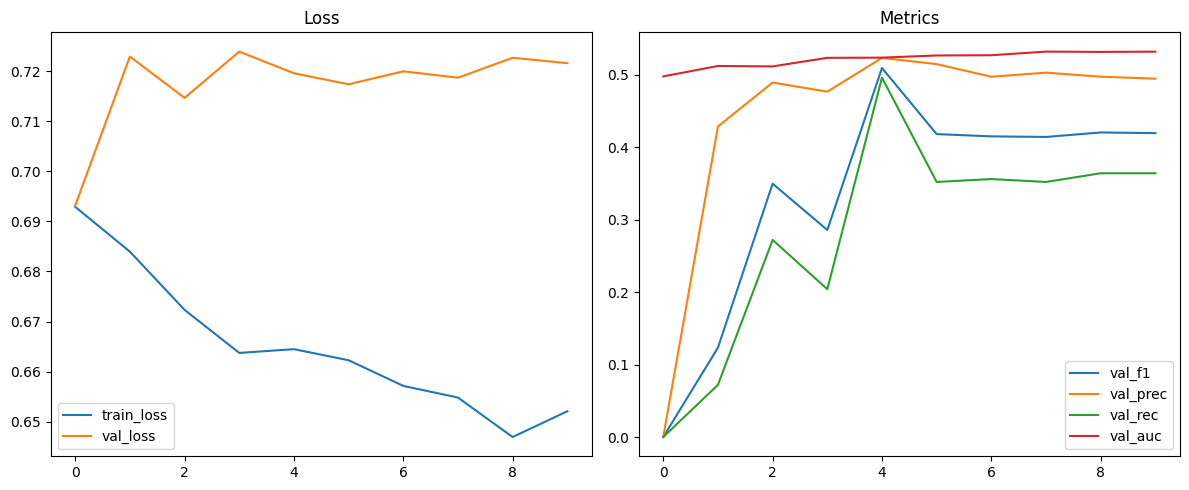

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'],  label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_f1'],  label='val_f1')
plt.plot(history['val_prec'],label='val_prec')
plt.plot(history['val_rec'], label='val_rec')
plt.plot(history['val_auc'], label='val_auc')
plt.legend(); plt.title("Metrics")
plt.tight_layout()
plt.show()